In [1]:
# DONE remove stopwords, punctuation tags and number tags
# DONE Lematize
# DONE Tokenize
# DONE Word embeddings
# TODO Word2Vec


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
# from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from glob import glob
import random
import os

In [3]:
tf.__version__

'2.4.0'

In [4]:
import pandas as pd
import re
import pickle
import numpy as np
pd.set_option('display.max_colwidth', None)

##### Count words with stopwords and symbols

In [5]:
import spacy

# from spacy.tokenizer import Tokenizer
import utils
nlp = spacy.load('en_core_web_md')
import en_core_web_sm


In [6]:
from spacy.lang.en.stop_words import STOP_WORDS
# (STOP_WORDS)

In [7]:
def read_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

data = read_from_pickle('data_clean.pkl')

In [8]:
data.tail()

,remove_stop_words,sent_count,num_count,clean_paragraph_len,contains_pron,label
4844,znum cup toast walnut pine nut znum small clove garlic znum cup coarsely chop carrot preferably organic big handful basil leave znum cup,1,4,23,0,1
4845,znum cup milk greek yogurt,1,1,5,0,1
4846,znum cup roll oats znum cup chop pecans znum cup flour kind zdot spelt oat wheat purpose gf blend znum cup brown sugar,1,4,23,0,1
4847,znum cup good quality coffee bean buy pron pre grind zdot znum cup filter water almond breeze almondmilk original znum cup latte,1,3,22,1,1
4848,znum cup slice leek tender white light green extra virgin olive oil drizzle znum garlic clove chop znum small zucchini chop znum strand spiralized julienned zucchini garnish znum cup hemp seed juice znum lemon taste,1,6,35,0,1


In [9]:
round(data['label'].value_counts()/len(data)*100,2)

0    79.71
1    20.29
Name: label, dtype: float64

In [10]:
train = pd.read_pickle('C:\\Users\\galin\\PycharmProjects\\aiAssignment\\data\\train_data_clean.pkl')
round(train['label'].value_counts()/len(train)*100,2)

0    79.71
1    20.29
Name: label, dtype: float64

In [11]:
test = pd.read_pickle('C:\\Users\\galin\\PycharmProjects\\aiAssignment\\data\\test_data_clean.pkl')
round(test['label'].value_counts()/len(test)*100,2)

0    79.71
1    20.29
Name: label, dtype: float64

In [12]:
maxSequenceLength_train = train['clean_paragraph_len'].max()#121 91-seed 42
maxSequenceLength_test = test['clean_paragraph_len'].max() #86 91-seed 42
maxSequenceLength_test, maxSequenceLength_train #(81, 91),

(81, 121)

In [13]:
#Sentences array for train and test sets + target variable for train and test
text_train = train['remove_stop_words']
y_train = train['label']

text_test = test['remove_stop_words']
y_test = test['label']

def get_max_sequence_len(series):
    max_words = 0
    for desc in series:
        words = len(desc.split())
        if words > max_words:
            max_words = words
    print(f'Max length in paragraph : {max_words} words')
    return max_words

max_sequence_length = get_max_sequence_len(text_train)#121
maxSequenceLength_test = get_max_sequence_len(text_test)#121
print(max_sequence_length,maxSequenceLength_test)
#(82, 121) --> max sent len in whole data is 121

Max length in paragraph : 121 words
Max length in paragraph : 81 words
121 81


### Tockenization of train set


In [14]:
max_sequence_length

121

In [15]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train)
# # top 15 max_count by wordsin our data
# tokenizer.word_counts                               
# sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

In [16]:
# total_words = len(tokenizer.word_index)
# print(f'In vocab {total_words} words')
# #In vocab 2303 words

In [17]:
# print(textSequences_train[:3])

In [18]:

def prep_text(texts, max_sequence_length):
    """ Create a union train set vocabulary and turn text in set
    into  padded sequences (word --> num )
    :param texts: series of prepared strings
           max_sequence_length: int max len of sentence in series
    :return ndArray with transformed series of text to int
            with 0-padding up to max_sequence_length"""
    # we will use only first most common 1000 words
    tokenizer1 = Tokenizer()
    tokenizer1.fit_on_texts(texts)
    vocab_size = len(tokenizer1.word_counts)
    
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(texts)
    print('vocab len',vocab_size,len(tokenizer.word_index))
    # Turn text into  padded sequences (word --> num )
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen=max_sequence_length,
                         dtype="int32", padding="post", value=0), vocab_size




### Fot train set

In [19]:
sent2vec_train, vocab_size_train = prep_text(text_train, max_sequence_length)

# index_max_len_sent = train[train['clean_paragraph_len'] == max_sequence_length].index 
# sent2vec_train[index_max_len_sent]

vocab len 2190 2190


In [20]:
# train[train['clean_paragraph_len'] == max_sequence_length]

In [21]:
print(sent2vec_train.shape)
print((train[['sent_count','num_count','clean_paragraph_len','contains_pron']].values).shape)

(3395, 121)
(3395, 4)


In [22]:
X_train = sent2vec_train #np.hstack((sent2vec_train, train[['sent_count','num_count','clean_paragraph_len','contains_pron']].to_numpy()))
y_train = train['label'].to_numpy().reshape(-1,1)

X_train.shape, y_train.shape


((3395, 121), (3395, 1))

### For test set

In [23]:
sent2vec_test, vocab_size_test = prep_text(text_test, maxSequenceLength_test)
# index_max_len_sent_test = test[test['clean_paragraph_len'] == maxSequenceLength_test].index #Int64Index([2373], dtype='int64')
# sent2vec_test[index_max_len_sent_test]

vocab len 1666 1666


In [24]:
X_test = sent2vec_test              #np.hstack((sent2vec_test, test[['sent_count','num_count','clean_paragraph_len','contains_pron']].to_numpy()))
y_test = test['label'].to_numpy().reshape(-1,1)

X_test.shape, y_test.shape


((1454, 81), (1454, 1))

In [25]:
# test[test['clean_paragraph_len'] == maxSequenceLength_test]

### Simple Neural Network

In [26]:
# NUM_WORDS=2000 # we will use
SEQ_LEN=121 # max len sequence
EMBEDDING_SIZE=128
BATCH_SIZE=128
EPOCHS=200
THRESHOLD=0.5


In [27]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size_train, EMBEDDING_SIZE),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(1, activation='sigmoid')])

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss'
          , mode='min')
callbacks=[es]
history = model.fit(X_train, y_train
                    , batch_size=BATCH_SIZE
                    , epochs=EPOCHS
                    , validation_data=(X_test, y_test)
                    , callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         280320    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 280,449
Trainable params: 280,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
27/27 [==============================] - 5s 69ms/step - loss: 0.6699 - accuracy: 0.6506 - val_loss: 0.5901 - val_accuracy: 0.7971
Epoch 2/200
27/27 [==============================] - 0s 15ms/step - loss: 0.5655 - accuracy: 0.7901 - val_loss: 0.5169 - val_accuracy: 0.7971
Epoch 3/200
27/27 [==============================] - 0s 14ms/step - loss: 0.5007 - accuracy: 0.7

In [28]:
score = model.evaluate(X_test, y_test,
                       batch_size=BATCH_SIZE, verbose=1)
print()
print(u'Model Loss score: {}'.format(score[0]))
print(u'Model Accuracy Evaluation : {}'.format(score[1]))


12/12 [==============================] - 0s 3ms/step - loss: 0.1739 - accuracy: 0.9243

Model Loss score: 0.1739341914653778
Model Accuracy Evaluation : 0.9243466258049011


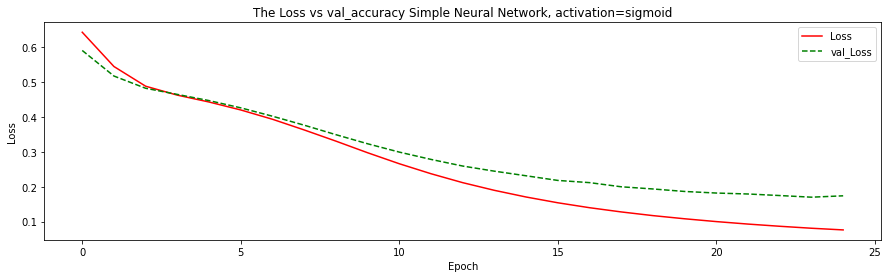

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'],'r', label='Loss')
plt.plot(history.history['val_loss'],'g--', label = 'val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 0.5])
# plt.xlim([0, 20])
plt.title('The Loss vs val_accuracy Simple Neural Network, activation=sigmoid')
plt.legend(loc='best');

In [30]:
THRESHOLD=0.5
preds = model.predict(X_test)

pred_df = pd.DataFrame(columns=['text', 'pred_label'])
pred_df['text'] = text_test
pred_df['pred_label'] = preds
pred_df['label'] = y_test
pred_df['label'] = pred_df['label'].apply(lambda x: 'Instructions' if x==0 else 'Recepie')
pred_df['pred_label'] = pred_df['pred_label'].apply(lambda x: 'Recepie' if x > THRESHOLD else 'Instructions')
pred_df[548:600]

,text,pred_label,label
548,large egg,Instructions,Recepie
549,season salt pepper taste sprinkle feta parsley avocado microgreen use zdot serve toasted bread scoop zdot,Instructions,Instructions
550,pickled veggie zdot place radish carrot cucumber jalapeno slice medium sized jar zdot small bowl whisk rice white wine vinegar sugar salt pour mixture jar vegetable zdot chill fridge znum hour overnight zdot,Instructions,Instructions
551,znum cup heavy cream brush znum chamomile tea bag znum znum cup purpose flour znum cup cane sugar plus sprinkle znum teaspoon baking powder,Recepie,Recepie
552,place sheet oven start check znum minute zdot leek tofu eggplant roast znum znum minute golden brown edge form tofu eggplant break tender zdot note zdot leek come zdot continue roast potato squash golden brown znum minute zdot,Instructions,Instructions
553,spread panko plate flat surface mix pinche salt pepper sesame seed zdot roll patty panko mix covering liberally set aside zdot,Instructions,Instructions
554,note pron pron waffle maker high let pron cook bit long initial znum ready beep zdot znum,Instructions,Instructions
555,znum daikon radish slice matchstick znum carrots slice matchstick znum medium cucumber slice matchstick znum jalapeno pepper thinly slice znum cup rice vinegar znum cup white wine vinegar pinch cane sugar pinch sea salt,Instructions,Recepie
556,arrange pepper tray mushroom onion wedge separate rimmed plate zdot small bowl whisk avocado oil garlic chili powder cumin salt grind pepper zdot drizzle znum scant tablespoon mixture pepper toss coat zdot drizzle remain marinade mushroom onion zdot drizzle mushroom splash balsamic vinegar use pron hand coat mushroom zdot,Instructions,Instructions
557,large skillet heat oil medium heat zdot add kale garlic pinche salt grind pepper zdot saut znum znum znum minute toss pron like use tong kale wilt zdot,Instructions,Instructions


In [31]:
model.save('simpleNN_model.h5')

### LSTM

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

# max count word to analize
# max_features = len(X_train)
# NUM_WORDS=2000 # we will use
SEQ_LEN=121 # max len sequence
EMBEDDING_SIZE=256
BATCH_SIZE=128
EPOCHS=200
THRESHOLD=0.5

print(u'Collecting the model')
lstm = Sequential()
lstm.add(Embedding(vocab_size_train, EMBEDDING_SIZE, mask_zero=True))
lstm.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
lstm.add(Dense(1, activation='relu'))

lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         560640    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                82176     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 642,881
Trainable params: 642,881
Non-trainable params: 0
_________________________________________________________________
None


In [33]:

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss'
          , mode='min')
callbacks=[es]

print(u'Model training')
history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=100,
          validation_split=0.2,
          callbacks=callbacks)


Model training
Epoch 1/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0744 - accuracy: 0.9838 - val_loss: 0.0620 - val_accuracy: 0.9971
Epoch 2/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0709 - accuracy: 0.9864 - val_loss: 0.0586 - val_accuracy: 0.9956
Epoch 3/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0677 - accuracy: 0.9867 - val_loss: 0.0565 - val_accuracy: 0.9971
Epoch 4/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0649 - accuracy: 0.9886 - val_loss: 0.0533 - val_accuracy: 0.9971
Epoch 5/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0619 - accuracy: 0.9878 - val_loss: 0.0514 - val_accuracy: 0.9971
Epoch 6/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0594 - accuracy: 0.9901 - val_loss: 0.0491 - val_accuracy: 0.9971
Epoch 7/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0570 - accuracy: 0.9893 - val_loss: 0.0474 - val_accuracy

In [34]:
score = model.evaluate(X_test, y_test,
                       batch_size=BATCH_SIZE, verbose=1)
print()
print(u'Model Loss score: {}'.format(score[0]))
print(u'Model Accuracy Evaluation : {}'.format(score[1]))


12/12 [==============================] - 0s 3ms/step - loss: 0.1520 - accuracy: 0.9395

Model Loss score: 0.15204912424087524
Model Accuracy Evaluation : 0.9394773244857788


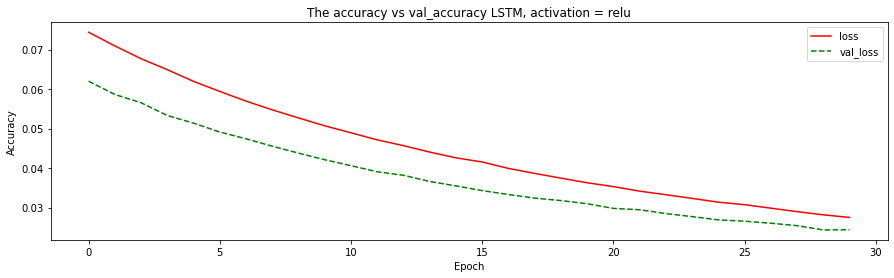

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'],'r', label='loss')
plt.plot(history.history['val_loss'],'g--', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 0.5])
# plt.xlim([0, 20])
plt.title('The accuracy vs val_accuracy LSTM, activation = relu')
plt.legend(loc='best');

In [36]:
THRESHOLD=0.5
preds = model.predict(X_test)

pred_df = pd.DataFrame(columns=['text', 'pred_label'])
pred_df['text'] = text_test
pred_df['pred_label'] = preds
pred_df['label'] = y_test
pred_df['label'] = pred_df['label'].apply(lambda x: 'Instructions' if x==0 else 'Recepie')
pred_df['pred_label'] = pred_df['pred_label'].apply(lambda x: 'Recepie' if x > THRESHOLD else 'Instructions')
pred_df[548:600]

,text,pred_label,label
548,large egg,Instructions,Recepie
549,season salt pepper taste sprinkle feta parsley avocado microgreen use zdot serve toasted bread scoop zdot,Instructions,Instructions
550,pickled veggie zdot place radish carrot cucumber jalapeno slice medium sized jar zdot small bowl whisk rice white wine vinegar sugar salt pour mixture jar vegetable zdot chill fridge znum hour overnight zdot,Instructions,Instructions
551,znum cup heavy cream brush znum chamomile tea bag znum znum cup purpose flour znum cup cane sugar plus sprinkle znum teaspoon baking powder,Recepie,Recepie
552,place sheet oven start check znum minute zdot leek tofu eggplant roast znum znum minute golden brown edge form tofu eggplant break tender zdot note zdot leek come zdot continue roast potato squash golden brown znum minute zdot,Instructions,Instructions
553,spread panko plate flat surface mix pinche salt pepper sesame seed zdot roll patty panko mix covering liberally set aside zdot,Instructions,Instructions
554,note pron pron waffle maker high let pron cook bit long initial znum ready beep zdot znum,Instructions,Instructions
555,znum daikon radish slice matchstick znum carrots slice matchstick znum medium cucumber slice matchstick znum jalapeno pepper thinly slice znum cup rice vinegar znum cup white wine vinegar pinch cane sugar pinch sea salt,Instructions,Recepie
556,arrange pepper tray mushroom onion wedge separate rimmed plate zdot small bowl whisk avocado oil garlic chili powder cumin salt grind pepper zdot drizzle znum scant tablespoon mixture pepper toss coat zdot drizzle remain marinade mushroom onion zdot drizzle mushroom splash balsamic vinegar use pron hand coat mushroom zdot,Instructions,Instructions
557,large skillet heat oil medium heat zdot add kale garlic pinche salt grind pepper zdot saut znum znum znum minute toss pron like use tong kale wilt zdot,Instructions,Instructions


In [37]:
model.save('simplelstm.h5')